In [1]:
import numpy as np
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
%matplotlib notebook
%matplotlib inline
import os



In [2]:
dta = np.loadtxt('data/incomes.txt')

### a)
Plot a histogram of percentages of the income.txt data with 30 bins. Make sure that the bins are weighted using the density=True option. Make sure your plot has correct x-axis and y-axis labels as well as a plot title.

(0, 150000)

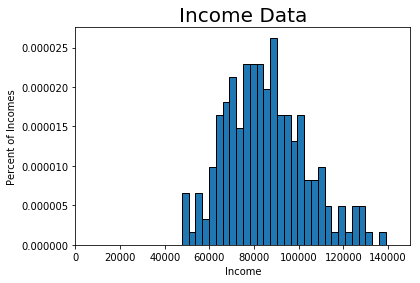

In [3]:
num_bins = 30
count, bins, ignored = plt.hist(dta, num_bins, density=True,
                                edgecolor='k')
plt.title('Income Data', fontsize=20)
plt.xlabel(r'Income')
plt.ylabel(r'Percent of Incomes')
plt.xlim([0, 150000])

### b)
Estimate the parameters of the lognormal distribution by generalized method of moments. Use the average income and standard deviation of income as your two moments. Use the identity matrix as your weighting matrix $\hat{W}$ . Plot your estimated lognormal PDF against the histogram from part (a). Report the value of your GMM criterion function at the estimated parameter values. Report and compare your two data moments against your two model moments at the estimated parameter values.


In [45]:
cut_lb = 0
cut_ub = 150000
mu_init = 11
sig_init = .5

In [46]:
def log_norm(xvals,mu,sigma, cut_lb, cut_ub):
    if cut_ub == 'None' and cut_lb == 'None':
        prob_notcut = 1.0
    elif cut_ub == 'None' and cut_lb != 'None':
        prob_notcut = 1.0 - sts.norm.cdf(cut_lb, loc=mu, scale=sigma)
    elif cut_ub != 'None' and cut_lb == 'None':
        prob_notcut = sts.norm.cdf(cut_ub, loc=mu, scale=sigma)
    elif cut_ub != 'None' and cut_lb != 'None':
        prob_notcut = (sts.norm.cdf(cut_ub, loc=mu, scale=sigma) -
                       sts.norm.cdf(cut_lb, loc=mu, scale=sigma))
    pdf_vals = ((1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))))/(prob_notcut)
    return pdf_vals

In [47]:
def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), variance(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar, mean value of test scores data
    var_data  = scalar > 0, variance of test scores data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, var_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    var_data = xvals.var()
    
    return mean_data, var_data


def model_moments(mu, sigma, cut_lb, cut_ub):
    #Why is the data not an input? Truncated normal is continuous distr that we're potentially using to calculate expected value.
    #All you need to know is the bounds
    xfx = lambda x: x * log_norm(x, mu, sigma, cut_lb, cut_ub)
    (mean_model, m_m_err) = intgr.quad(xfx, cut_lb, cut_ub)
    x2fx = lambda x: ((x - mean_model) ** 2) * log_norm(x, mu, sigma, cut_lb, cut_ub) 
    (var_model, v_m_err) = intgr.quad(x2fx, cut_lb, cut_ub)
    
    return mean_model, var_model #mean and variance of model distributions


def err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple):
    mean_data, var_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [var_data]])
    mean_model, var_model = model_moments(mu, sigma, cut_lb, cut_ub)
    moms_model = np.array([[mean_model], [var_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    mu, sigma = params
    xvals, cut_lb, cut_ub, W = args
    err = err_vec(xvals, mu, sigma, cut_lb, cut_ub, simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [48]:

params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (dta, cut_lb, cut_ub, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       tol=1e-7, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
results
#only using two moments of distribution to identify parameters

mu_GMM1= 11.336909418504783  sig_GMM1= 0.21302747638067634


      fun: array([[4.73980413e-12]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.14893283e-06, 3.39760877e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 51
      nit: 10
   status: 0
  success: True
        x: array([11.33690942,  0.21302748])

In [ ]:
mu_init = 11
sig_init = .5

In [53]:
def log_norm(xvals,mu,sigma):
    pdf_vals = ((1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                    np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2))))
    return pdf_vals

In [54]:
def data_moments(xvals):
    '''
    --------------------------------------------------------------------
    This function computes the two data moments for GMM
    (mean(data), variance(data)).
    --------------------------------------------------------------------
    INPUTS:
    xvals = (N,) vector, test scores data
    
    OTHER FUNCTIONS AND FILES CALLED BY THIS FUNCTION: None
    
    OBJECTS CREATED WITHIN FUNCTION:
    mean_data = scalar, mean value of test scores data
    var_data  = scalar > 0, variance of test scores data
    
    FILES CREATED BY THIS FUNCTION: None
    
    RETURNS: mean_data, var_data
    --------------------------------------------------------------------
    '''
    mean_data = xvals.mean()
    var_data = xvals.var()
    
    return mean_data, var_data


def model_moments(mu, sigma):
    #Why is the data not an input? Truncated normal is continuous distr that we're potentially using to calculate expected value.
    #All you need to know is the bounds
    xfx = lambda x: x * log_norm(x, mu, sigma)
    (mean_model, m_m_err) = intgr.quad(xfx, 0, 150000)
    x2fx = lambda x: ((x - mean_model) ** 2) * log_norm(x, mu, sigma) 
    (var_model, v_m_err) = intgr.quad(x2fx, 0, 150000)
    
    return mean_model, var_model #mean and variance of model distributions


def err_vec(xvals, mu, sigma, simple):
    mean_data, var_data = data_moments(xvals)
    moms_data = np.array([[mean_data], [var_data]])
    mean_model, var_model = model_moments(mu, sigma)
    moms_model = np.array([[mean_model], [var_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    mu, sigma = params
    xvals, W = args
    err = err_vec(xvals, mu, sigma,simple=False)
    crit_val = err.T @ W @ err
    
    return crit_val

In [55]:
params_init = np.array([mu_init, sig_init])
W_hat = np.eye(2)
gmm_args = (dta, W_hat)
results = opt.minimize(criterion, params_init, args=(gmm_args),
                       tol=1e-7, method='L-BFGS-B',
                       bounds=((1e-10, None), (1e-10, None)))
mu_GMM1, sig_GMM1 = results.x
print('mu_GMM1=', mu_GMM1, ' sig_GMM1=', sig_GMM1)
results

mu_GMM1= 11.336909418504783  sig_GMM1= 0.21302747638067634


      fun: array([[4.73980413e-12]])
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([4.14893283e-06, 3.39760877e-05])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 51
      nit: 10
   status: 0
  success: True
        x: array([11.33690942,  0.21302748])

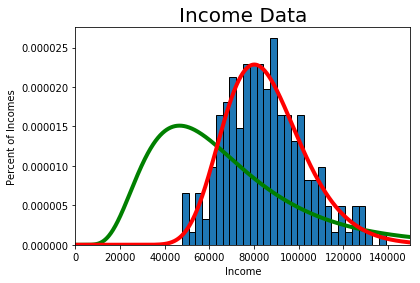

In [60]:
#Graph
x_pts = np.linspace(.01,150000,1000)
#Histogram
num_bins = 30
count, bins, ignored = plt.hist(dta, num_bins, density=True,
                                edgecolor='k')
plt.title('Income Data', fontsize=20)
plt.xlabel(r'Income')
plt.ylabel(r'Percent of Incomes')
plt.xlim([0, 150000])

#Original Estimates
plt.plot(x_pts,log_norm(x_pts,mu_init,sig_init),linewidth=4, color='g')

#GMM Estimates
plt.plot(x_pts,log_norm(x_pts,mu_GMM1,sig_GMM1),linewidth=4, color='r')

### c) 
Perform the two-step GMM estimator by using your estimates from part (b) with two moments to generate an estimator for the variance covariance matrix $\hat{\Omega}_{2 step}$, which you then use to get the two-step estimator for the optimal weighting matrix $\hat{W}_{2 step}$. Report your estimates as well as the criterion function value at these estimates. Plot your estimated lognormal PDF against the histogram from part (a) and the estimated PDF from part (b). Report and compare your two data moments against your two model moments at the estimated parameter values.